In [1]:
#!pip install -q git+https://github.com/huggingface/transformers.git
#!pip install -q datasets sentencepiece

In [2]:
import torch
import re
from PIL import Image

## Question answering from a cover page

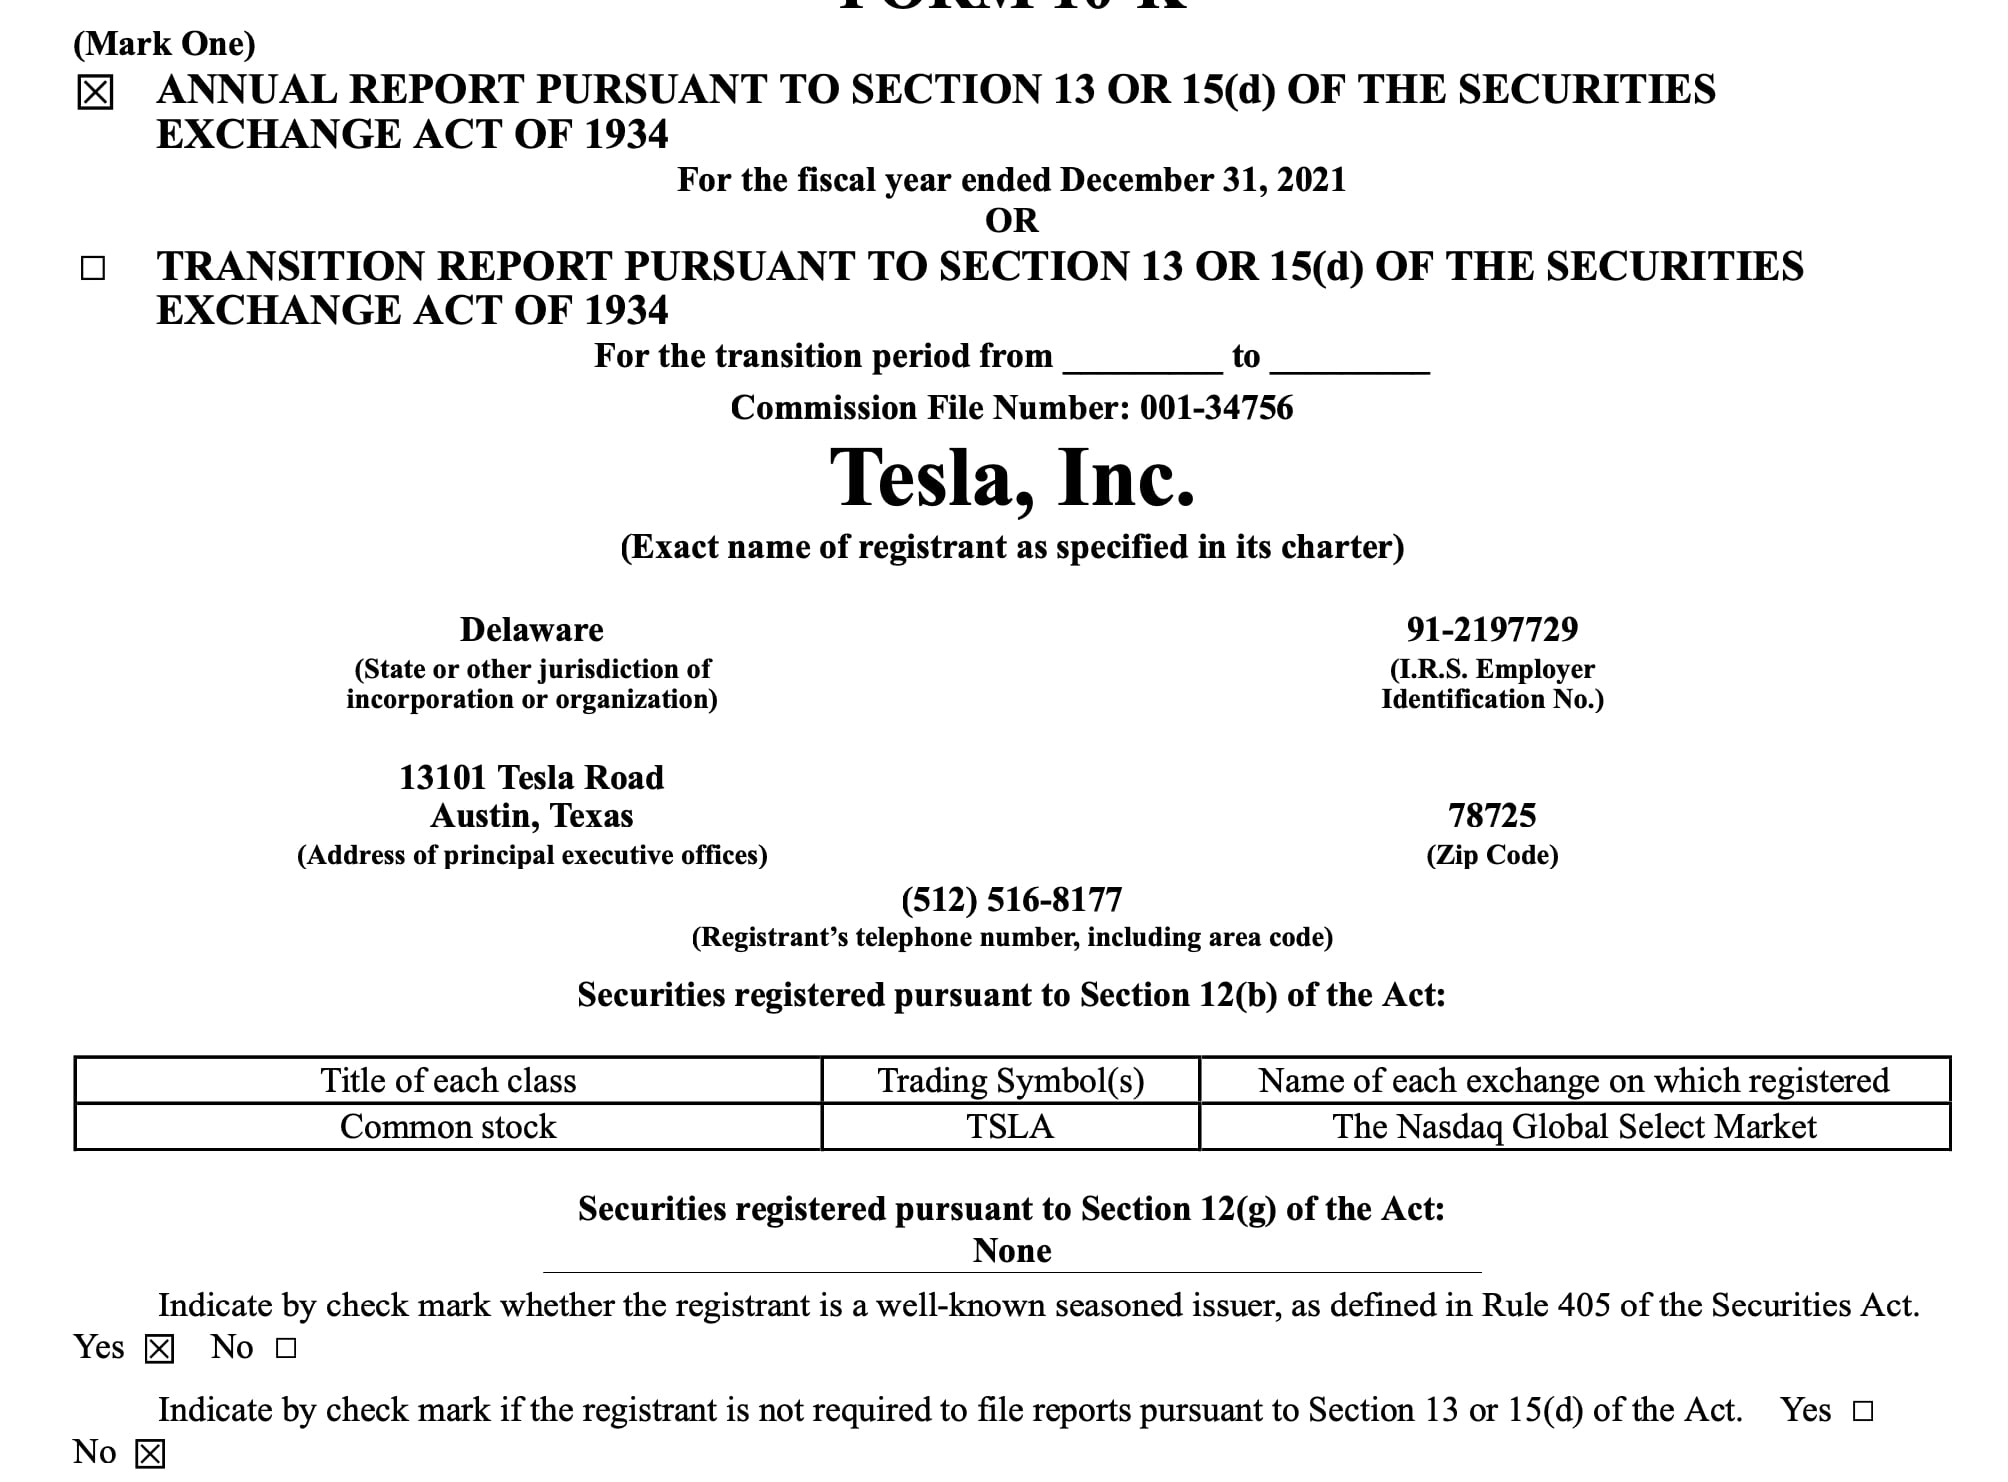

In [9]:
image = Image.open("tesla_cover_2.jpg")
image.show()

In [10]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [14]:
questions = ["what is the trading symbol?",
             "what is the name of each exchange where it is registered?",
             "is the registrant registrant is not required to file reports pursuant to Section 13 or 15(d) of the Act?",
             "is the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.",
             "what is the address of principal executive offices?",
             "what is the registrant's telephone number?",
             "what is the commision file number?",
             "what is the exact name of the registrant?",
            ]

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
for each in questions:
    question = each
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    print(processor.token2json(seq))

{'question': 'what is the trading symbol?', 'answer': 'tsla'}
{'question': 'what is the name of each exchange where it is registered?', 'answer': 'the nasdaq global select market'}
{'question': 'is the registrant registrant is not required to file reports pursuant to Section 13 or 15(d) of the Act?', 'answer': 'no'}
{'question': 'is the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.', 'answer': 'yes'}
{'question': 'what is the address of principal executive offices?', 'answer': '(512) 516-8177'}
{'question': "what is the registrant's telephone number?", 'answer': '(512) 516-8177'}
{'question': 'what is the commision file number?', 'answer': '001-34756'}
{'question': 'what is the exact name of the registrant?', 'answer': '(ir.s. employer)'}


## Question answering from a table

In [15]:
image = Image.open("tesla_revenues.jpg")

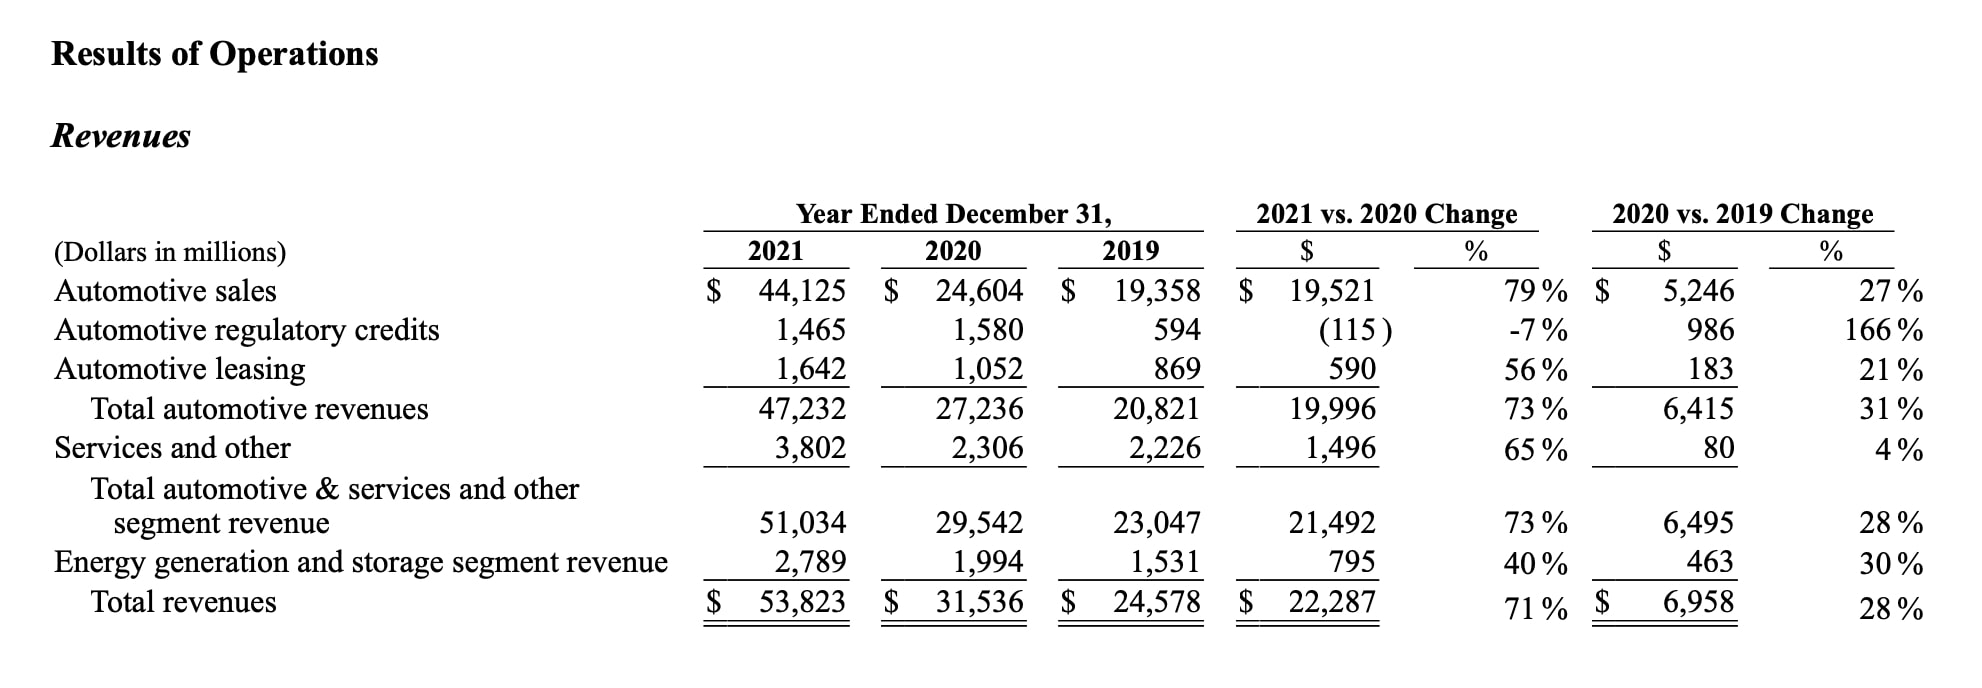

In [16]:
image.show()

In [17]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])


In [18]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
questions = ["what is the total revenues in 2021?",
             "what is the total automotive revenues in 2019?",
             "what is the 2021 vs 2020 % change for energy generation?"
            ]

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
for each in questions:
    question = each
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    print(processor.token2json(seq))

{'question': 'what is the total revenues in 2021?', 'answer': '$ 53,823'}
{'question': 'what is the total automotive revenues in 2019?', 'answer': '20,821'}
{'question': 'what is the 2021 vs 2020 % change for energy generation?', 'answer': '40%'}


## OCR from text page

In [19]:
image = Image.open("statement.jpg")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])


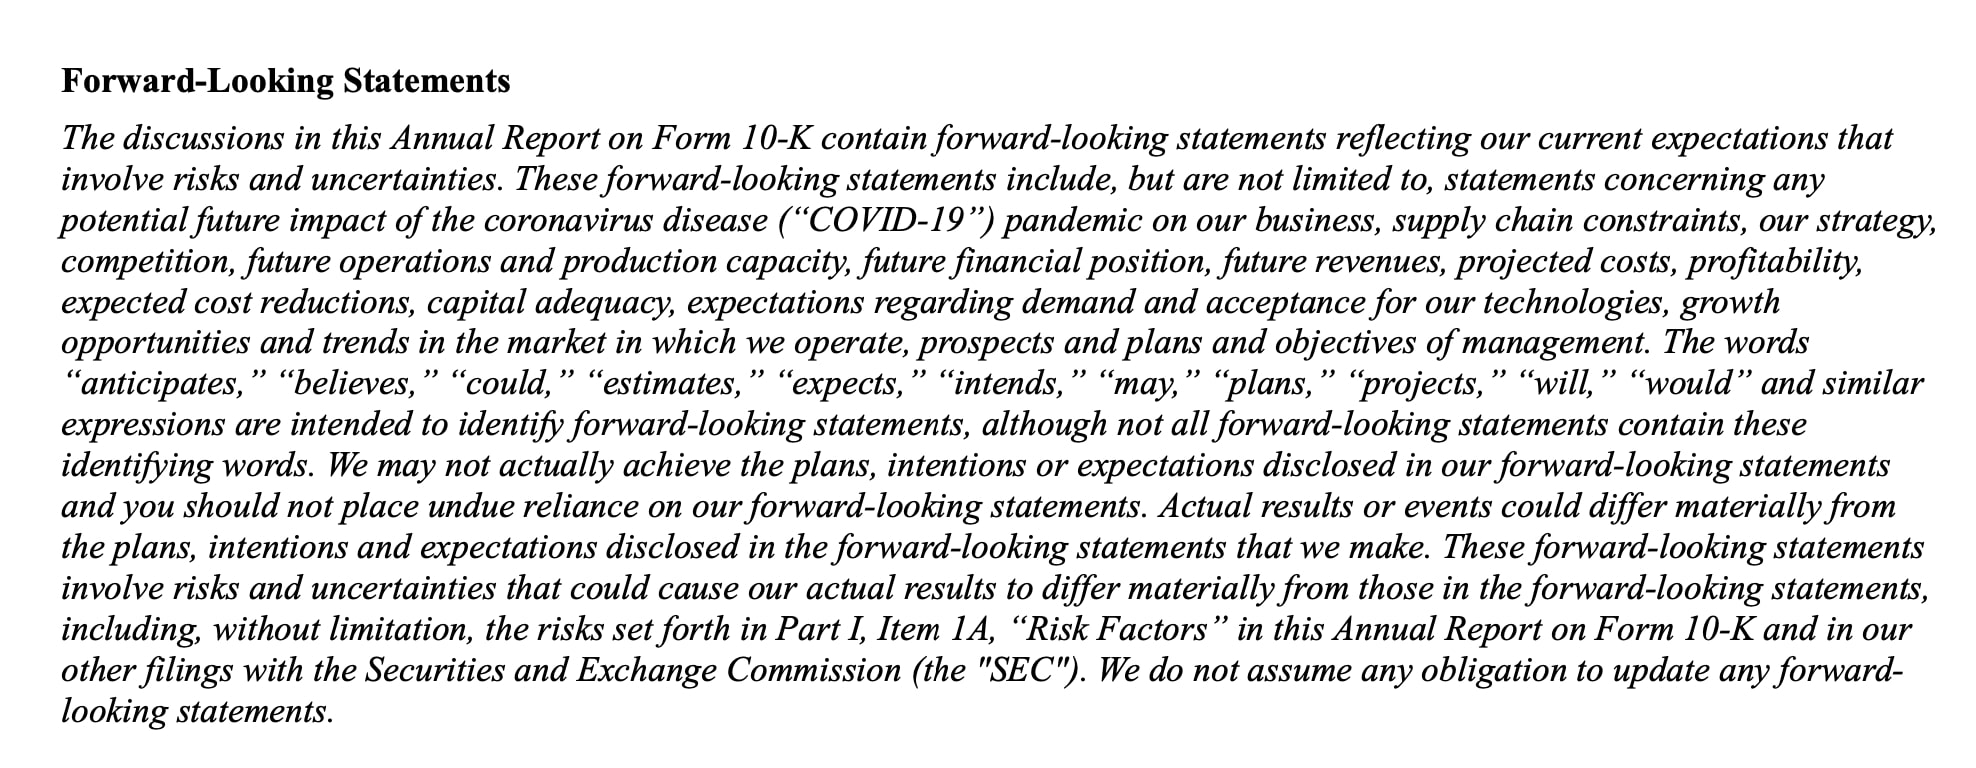

In [20]:
image.show()

In [21]:
task_name = "synthdog"
task_prompt = f"<s_{task_name}>"

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([1, 3, 1280, 960])


In [22]:
task_prompt = task_prompt
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [23]:

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> Forward-Looking Statements The discussions in this Annual Report on Form 10-K contain forward-looking statements reflecting our current expectations that involve risks and uncertainties. These forward-looking statements include. but are not limited to. statements concerning any potential future impact of the coronavirus disease ("COVID-19") pandemic on our business supply chain constraints, our strategic; competition, future operations and production capacty, future financial poston, future revenues, projected costs, profitability, expected to restrictions capital adequacy, expectations regarding demand academic for our technologies, growth opportunities and trends in the market in which we operate, prospers and plans and objectives of management. The words "anticipates" "believes," includes "expects, "tends" may's plots, projects." "well." would" and similarly statements, although not allow-looking statements contain these experiences are intended to identify forward-lo

In [24]:
image = Image.open("page_1.jpg")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


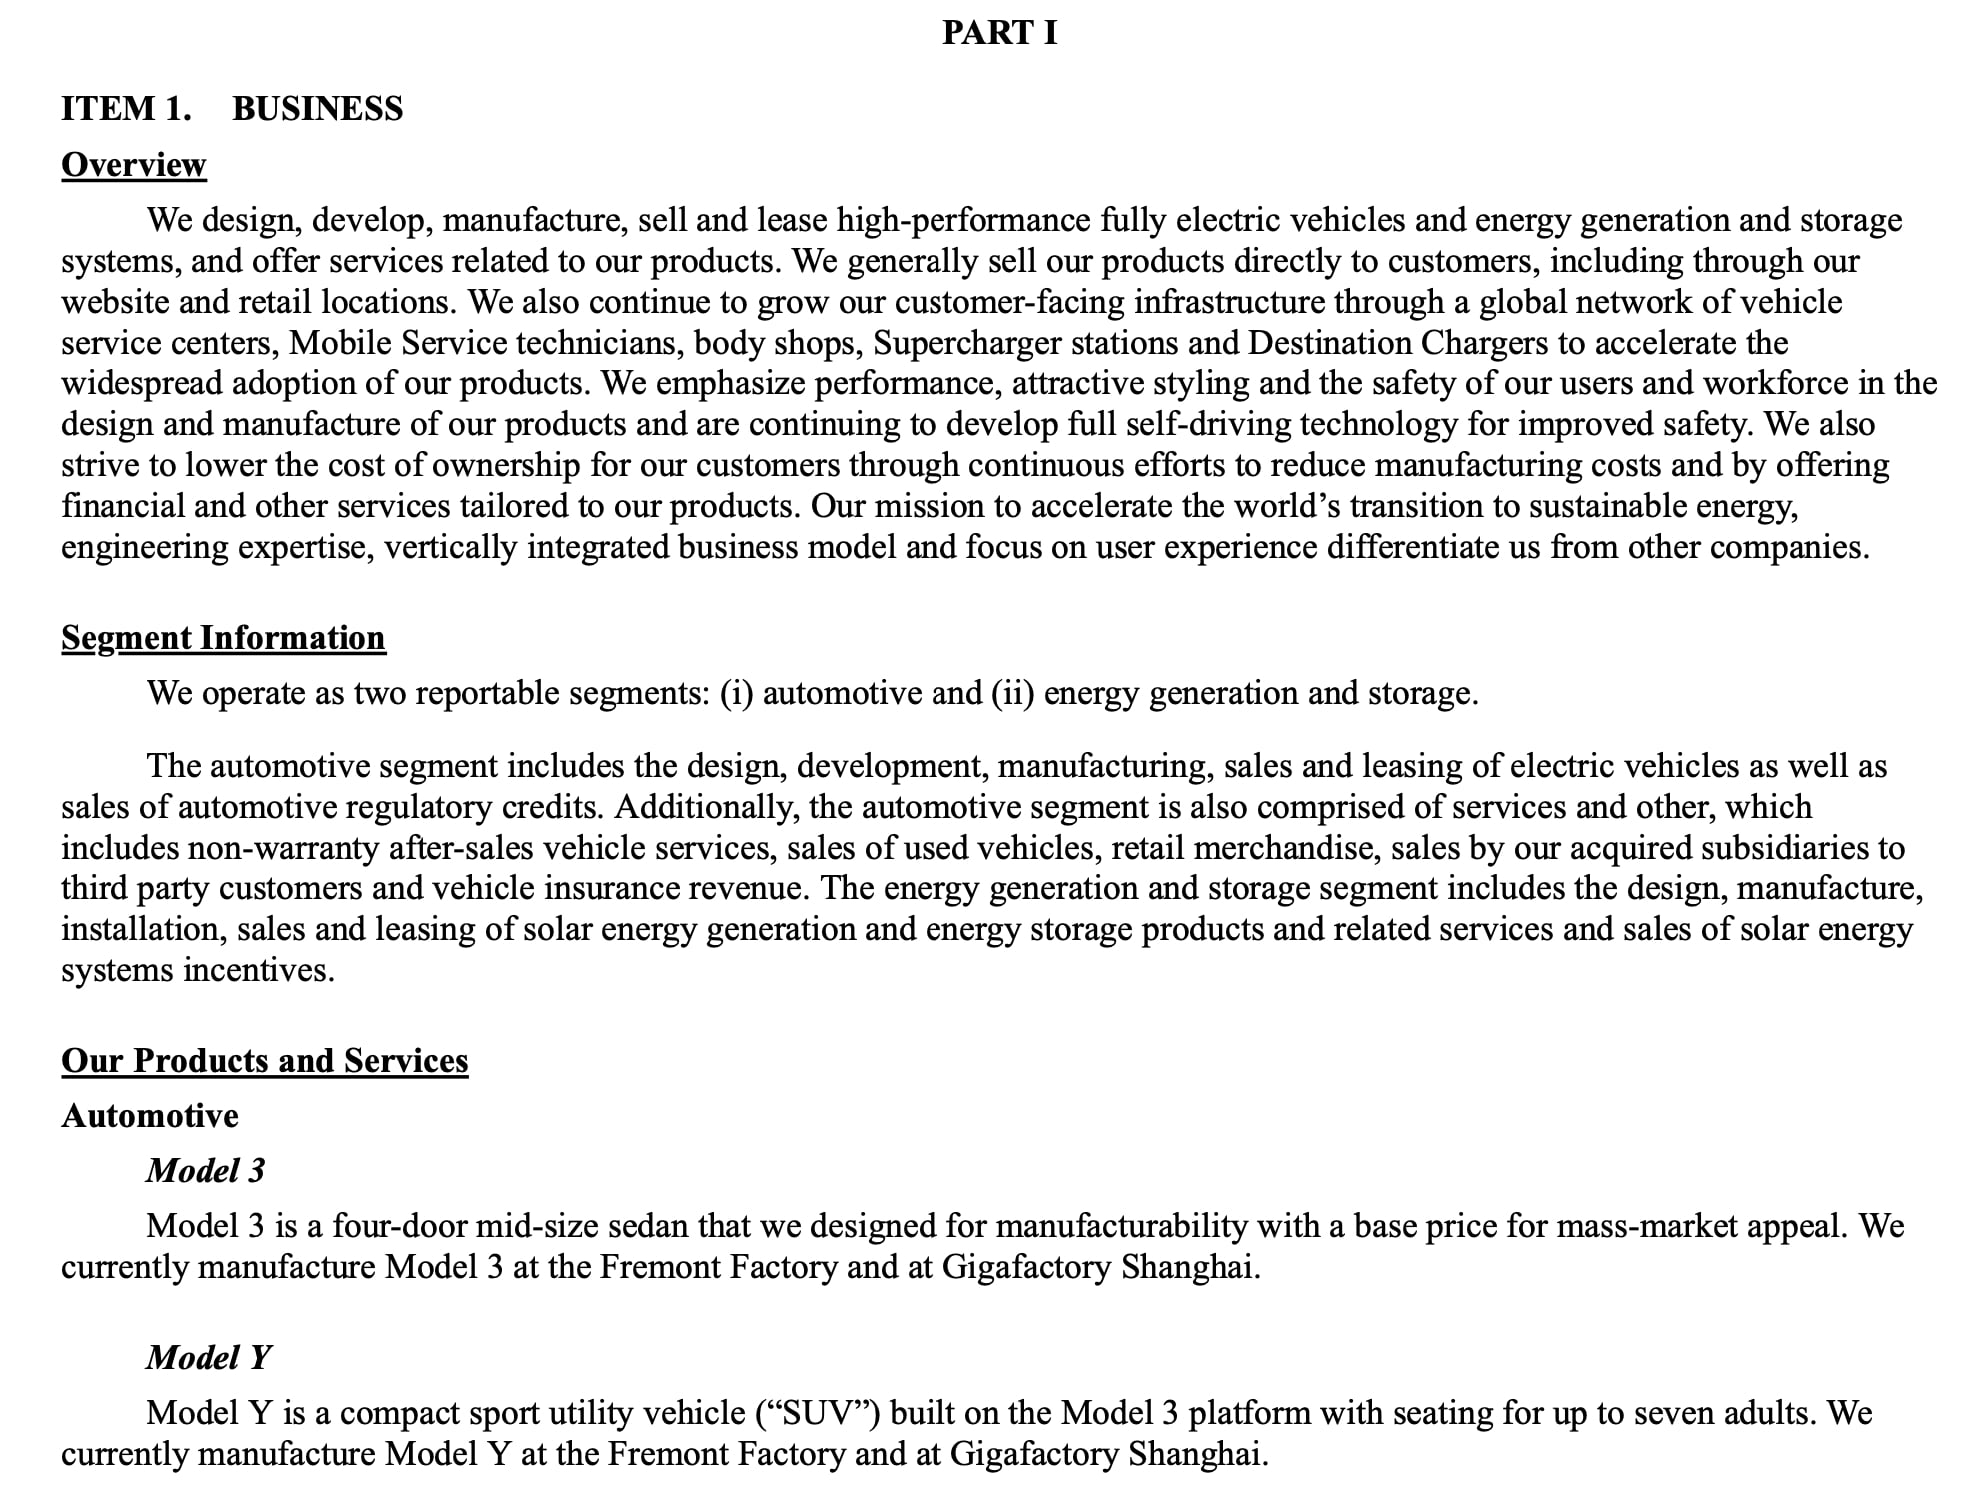

In [25]:
image.show()

In [28]:
task_prompt = task_prompt
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

PARTI ITEM 1. BUSINESS수로view We design, develop, manufacture, sell and lease high-performanc 않는다 vehicles vehicles and energy generation and storage systems, and offer services related to our products. We generally sell our products directly to customers, including through our planet and wellness and realized locations. We also continue to grow our custorf-facture infrastructure through a global network of vehicle service centres. Mobile Service tethricians, body shops. Supercharger stations and Destination Charges to accelerate the widespread adoption of our products. We emphasize performance, attractive styling and the safety of our users and workforce in the design and manufacture of our products and service to develop full self-fidriving technology for improved safety. We also strive to lower the cost of ownship for our customers through continuous efforts to reduce manufacturers costs and by offering financial and other services tailored to our products. Our mission to accelerate 